# Problem Set 3

### Before You Start

This problem set is fun but challenging. It's going to involve a good amount of debugging and head-scratching, so try to start sooner rather than later!

This problem set has three parts:

- **Part I**: Experimental Setup
- **Part II**: Nearest Neighbor and Cross-Validation
- **Part III**: Overfitting in Model Selection and Nested Cross Validation

For part I and II we'll consider a regression problem. You should *not* be using any built-in ML libraries for nearest neighbors, distance metrics, or cross-validation -- your mission is to write those algorithms in Python! For these two first parts we will be working with a modified version of the California Housing Dataset that you can download from bcourses (`cal_housing_data_clean.csv`). Part I will be relatively easy; Part II will take more time.

For part III we'll consider a classification problem. You'll be able to use Python ML built-in libraries (in particular scikit-learn). We'll not be using the California Housing Dataset but rather synthetic data that you'll generate yourself. 

Make sure the following libraries load correctly before starting (hit Ctrl-Enter).

In [2]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn
import time

In [3]:
%matplotlib inline  
import matplotlib.pyplot as plt  

---

## Introduction to the assignment

For this assignment, you will be using a version of the [California Housing Prices Dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) with additional information. Use the following commands to load the information in the csv file provided with the assignment in bcourses (`cal_housing_data_clean.csv`). Take some time to explore the data. 

In [4]:
# load Cal data set
cal_df = pd.read_csv('cal_housing_data_clean.csv')
features = ['MedInc','HouseAge','AveRooms','AveBedrms','Population','DistCoast','Inland']
target = 'MedHouseVal'

---

# Part I: Experimental Setup

The goal of the next few sections is to design an experiment to predict the median home value for census block groups.
Before beginning the "real" work, refamiliarize yourself with the dataset.

### 1.1 Begin by writing a function to compute the Root Mean Squared Error for a list of numbers

You can find the sqrt function in the Numpy package. Furthermore the details of RMSE can be found on [Wikipedia](http://en.wikipedia.org/wiki/Root-mean-square_deviation). Do not use a built-in function  to compute RMSE, other than numpy functions like `sqrt` and if needed, `sum` or other relevant ones.

In [5]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Root Mean Squared Error

Parameters
----------
y_hat : array
    numpy array of numerical values corresponding to predictions for each of the N observations

y : array
    numpy array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : float
    Root Mean Squared Error of the prediction

Example
-------
>>> print(compute_rmse((4,6,3),(2,1,4)))
3.16
"""
def compute_rmse(y_hat, y):
    # your code here
    y_hat = np.array(y_hat)
    y = np.array(y)

    # Asserts
    assert isinstance(y, (np.ndarray, np.generic)) # unnecessary given above
    assert isinstance(y_hat, (np.ndarray, np.generic)) 
    assert np.size(y) == np.size(y_hat)

    n = np.sum(~np.isnan(y))
    
    return np.sqrt(np.sum((y_hat - y)**2)/n)

### 1.2 Divide your data into training and testing datasets

Randomly select 75% of the data and put this in a training dataset (call this "cal_df_train"), and place the remaining 25% in a testing dataset (call this "cal_df_test"). Do not use built-in functions.

To perform any randomized operation, only use functions in the *numpy library (np.random)*. Do not use other packages for random functions.

In [6]:
# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=1948)

# your code here

# Set values
test_prop = .25
n = len(cal_df)
test_n = int(np.ceil(n * test_prop))

indices = cal_df.index.values
np.random.shuffle(indices)
test_indices = indices[:test_n]
train_indices = indices[test_n:]

# Shuffle ids
# test_indices = np.random.choice(indices, size = test_n, replace=False)
# train_indices = np.array([i for i in indices if i not in test_indices])

assert np.intersect1d(test_indices, train_indices).shape[0] == 0
assert test_indices.shape[0] == test_n

# Create actual test/train
cal_df_test = cal_df.loc[test_indices,:]
cal_df_train = cal_df.loc[train_indices,:]

# Note: above is to ensure the exact amount of test subjects, and relies on more non-native functions
    # With sufficiently large n, this doesn't really matter, whereas speed and readability matter a lot more. 
    # So I'd probably do this:
# in_test = np.random.random_sample(n) < test_prop
# cal_df_test = cal_df[in_test]
# cal_df_train = cal_df[~in_test]

print(f"  n_sizes\ntest:   {len(cal_df_test)}\ntrain: {len(cal_df_train)}\ntotal: {len(cal_df)}")



  n_sizes
test:   5160
train: 15480
total: 20640


### 1.3 Use a baseline for prediction, and compute RMSE 

Let's start by creating a very bad baseline model that predicts median house values as the average of `MedHouseVal`.

Specifically, create a model that predicts, for every observation X_i, the median home value as the average of the median home values of block groups in the **training set**.

Once the model is built, do the following:

1. Report the RMSE of the training set and report it.
2. Report the RMSE of the test data set (but use the model you trained on the training set!).
3. How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?
4. Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicted values for the test data?
5. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in gold. Make sure to label your axes appropriately, and add a legend to your figure.

train RMSE:  1.193
test RMSE:   1.165
test set predicted in 0.000245 seconds


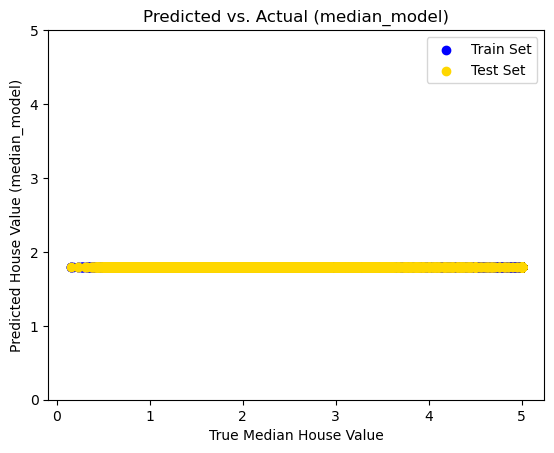

In [7]:
# your code here - `median_model`

# set true y
y = cal_df_train[target]

# Build (crappy) Model
median_model__y_hat_train = np.full(len(cal_df_train), np.median(cal_df_train[target])) # create array of size train_n with values all median 
assert np.size(median_model__y_hat_train) == n - test_n

# 1) Report the RMSE of train
median_model__rmse_train = compute_rmse(median_model__y_hat_train, cal_df_train[target])
print(f"train RMSE: {median_model__rmse_train: .3f}")

# 2) Report RMSE
median_model__y_hat_test = np.full(len(cal_df_test),np.median(cal_df_train[target]))
median_model__rmse_test = compute_rmse(median_model__y_hat_test, cal_df_test[target])
print(f"test RMSE:  {median_model__rmse_test: .3f}")

# 3) How do they compare
    # The train error is actually smaller than the test error. This is somewhat unexpected since the model is only using the data from the training set.
    # However, since the test set is smaller,...

# 4) Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicrted values for the test data?
t_start = time.time()
median_model__y_hat_test = np.full(len(cal_df_test), np.median(cal_df_train[target]))

t2 = time.time() - t_start
print(f"test set predicted in {t2:.6f} seconds") # This is just the amount of time to access MedHouseVal, calculate the median and create the array.
# I assume np.median is the slowest part of this since it has to run in test_n time

# 5) Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. 
    # Color the training instances in blue and test instances in gold. Make sure to albel your axes appropriately, and add a legend to your figure

plt.figure(0)
plt.scatter(cal_df_train[target], median_model__y_hat_train, color='blue', label = 'Train Set')
plt.scatter(cal_df_test[target], median_model__y_hat_test, color = 'gold', label = 'Test Set')
plt.xlabel('True Median House Value')
plt.ylabel('Predicted House Value (median_model)')
plt.legend()
plt.title('Predicted vs. Actual (median_model)')
plt.ylim(0, max(cal_df[target]))
plt.show()


*your answer here*

See comments above. This model is unsurprisingly fairly innacurate and thus the plot is both difficult and easy to interpret

### 1.4 Use another baseline for prediction, and compute RMSE [extra-credit]

Now consider a baseline model that predicts median house values as the averages of `MedHouseVal` based on whether the census block is adjacent to the coast or inland (note that the `Inland` feature is already computed and ready for you).

Specifically, create a model that predicts, for every observation X_i, the median home value as the average of the median home values of block groups in the **training set** that have the same adjacency value.

For example, for an input observation where `Inland==1`, the model should predict the `MedHouseVal` as the average of all `MedHouseVal` values in the training set that also have `Inland==1`.

Once the model is built, do the following:

1. Compute the RMSE of the training set.
2. Now compute the RMSE of the test data set (but use the model you trained on the training set!).
3. How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?
4. Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicted values for the test data?
5. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in gold. Make sure to label your axes appropriately, and add a legend to your figure to make clear which dots are which.
6. Compare this results to those obtained in 1.3. Is coast adjacency improving the predictions? 

*Note:* The `groupby` operation might come handy here.

train RMSE:   1.018
test RMSE:   0.984
test set predicted in 0.000372 seconds


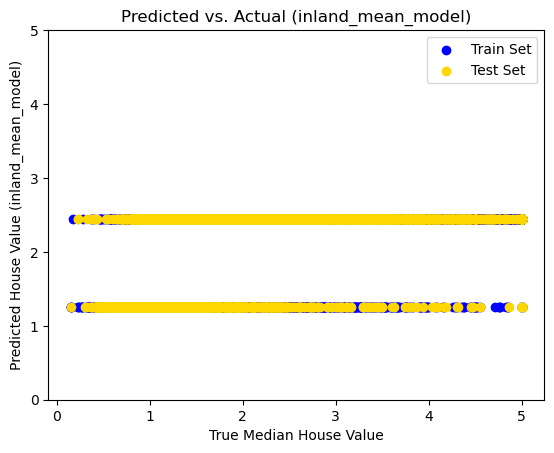

In [8]:
# your code here - `inland_mean_model`

# "train" model using groupby means
inland_mean_model__y_hat = (
    cal_df_train
    .groupby('Inland')
    .mean()
    ['MedHouseVal']
    .to_dict()
)

# predict y_hat_train/test using model
inland_mean_model__y_hat_train = cal_df_train['Inland'].map(inland_mean_model__y_hat)
inland_mean_model__y_hat_test = cal_df_test['Inland'].map(inland_mean_model__y_hat)

# 1) Compute RMSE of training set
inland_mean_model__rmse_train = compute_rmse(inland_mean_model__y_hat_train, cal_df_train[target])
print(f"train RMSE:  {inland_mean_model__rmse_train: .3f}")

# 2) Compute RMSE of test set
inland_mean_model__rmse_test = compute_rmse(inland_mean_model__y_hat_test, cal_df_test[target])
print(f"test RMSE:  {inland_mean_model__rmse_test: .3f}")

# 3) Again the test set has a lower error than the train set. Again this is generally unexpected in most cases, but here, with such a simple,
    # and brute-force model, the marginal difference between the sets is not really surprising.

# 4) Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicrted values for the test data?
t_start = time.time()
inland_mean_model__y_hat_test = np.full(len(cal_df_test), cal_df_test['Inland'].map(inland_mean_model__y_hat))

t2 = time.time() - t_start
print(f"test set predicted in {t2:.6f} seconds") # the same as before. Note: This ignores the actual model training, is that fine? TODO

# 5) Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. 
    # Color the training instances in blue and test instances in gold. Make sure to albel your axes appropriately, and add a legend to your figure

plt.figure(1)
plt.scatter(cal_df_train[target], inland_mean_model__y_hat_train, color='blue', label = 'Train Set')
plt.scatter(cal_df_test[target], inland_mean_model__y_hat_test, color = 'gold', label = 'Test Set')
plt.xlabel('True Median House Value')
plt.ylabel('Predicted House Value (inland_mean_model)')
plt.legend()
plt.title('Predicted vs. Actual (inland_mean_model)')
plt.ylim(0, max(cal_df[target]))
plt.show()

*your answer here*

6) Compare to 1.3

The avg error did go down, and we can see in the scatter plot that is largely because there is more specificity in the model as the appears to be real separation in the mean values for each group. This is still a very basic and simplistic model though.

---

# Part II: Nearest Neighbors and Cross-Validation
Let's try and build a machine learning algorithm to beat the "Average Values" baselines that you computed above. Your next task is to implement a basic nearest neighbor algorithm from scratch. 

### 2.1 Nearest Neighbors: Normalization

Create normalized analogues of all the features in both the training and test datasets. Recall that this involves substracting the **training** mean and dividing by the **training** standard deviation. 

Include the normalized features as additional columns in the train an test dataframes and call them 
`MedIncNorm, HouseAgeNorm, AveRoomsNorm, AveBedrmsNorm, PopulationNorm, AveOccupNorm, DistCoastNorm and InlandNorm` respectively.

In [9]:
# your code here

# Train
cal_df_train__norm_temp = cal_df_train.apply(lambda x: (x - np.nanmean(x)) / np.nanstd(x)).rename(columns = lambda x: x + 'Norm')
# (cal_df_train - cal_df_train.mean()) / cal_df_train.std() <- after looking it up, apparently this works too since pandas automatically applies colum-wise
cal_df_train__norm = pd.merge(cal_df_train, cal_df_train__norm_temp, left_index=True, right_index=True)
cal_df_train__norm = cal_df_train__norm.drop('MedHouseValNorm', axis=1)
cal_df_train__norm

# Test
cal_df_test__norm_temp = (cal_df_test - cal_df_train.mean()) / cal_df_train.std()
cal_df_test__norm_temp = cal_df_test__norm_temp.rename(columns = lambda x: x + 'Norm')
cal_df_test__norm = pd.merge(cal_df_test, cal_df_test__norm_temp, left_index=True, right_index=True)
cal_df_test__norm = cal_df_test__norm.drop('MedHouseValNorm', axis=1)
cal_df_test__norm

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,DistCoast,Inland,MedHouseVal,MedIncNorm,HouseAgeNorm,AveRoomsNorm,AveBedrmsNorm,PopulationNorm,AveOccupNorm,DistCoastNorm,InlandNorm
1425,6.6772,13,7.377072,1.067680,2288,3.160221,79883.439580,1,1.85600,1.478920,-1.239151,0.828149,-0.060029,0.761099,0.008310,0.819772,1.479521
639,8.4960,34,7.825971,1.050870,1817,2.432396,1827.026948,0,5.00001,2.436454,0.425490,1.017762,-0.096116,0.347431,-0.056379,-0.783381,-0.675851
3050,1.6505,50,3.838765,1.154374,2247,3.854202,19359.211980,0,1.25000,-1.167460,1.693789,-0.666417,0.126087,0.725090,0.069991,-0.423298,-0.675851
19925,2.5875,44,4.665468,1.104317,776,2.791367,119120.744600,1,0.68900,-0.674163,1.218177,-0.317221,0.018624,-0.566856,-0.024474,1.625643,1.479521
18701,1.3654,47,5.600000,1.289474,603,3.173684,158673.513000,1,0.57900,-1.317555,1.455983,0.077522,0.416122,-0.718798,0.009507,2.437993,1.479521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10029,3.3958,12,5.320242,1.031722,1780,2.688822,6235.576936,0,2.15800,-0.248621,-1.318420,-0.040647,-0.137223,0.314934,-0.033588,-0.692836,-0.675851
11380,2.9559,15,5.272152,1.110759,816,2.582278,217092.469700,1,1.18800,-0.480213,-1.080614,-0.060960,0.032455,-0.531725,-0.043057,3.637825,1.479521
16744,3.5987,31,4.227200,1.089600,1303,2.084800,3619.513352,0,3.40500,-0.141802,0.187684,-0.502344,-0.012970,-0.104004,-0.087273,-0.746566,-0.675851
8015,1.6792,43,3.255357,1.071429,2339,4.176786,5084.353693,0,1.30600,-1.152351,1.138908,-0.912846,-0.051981,0.805891,0.098662,-0.716481,-0.675851


### 2.2 Basic Nearest Neighbor algorithm

Use your training data to "fit" your model that predicts `MedHouseVal` from `MedIncNorm`, `HouseAgeNorm` and `AveRoomsNorm`, although as you know, with Nearest Neighbors there is no real training, you just need to keep your training data in memory.  Write a function that predicts the median home value using the nearest neighbor algorithm we discussed in class.  Since this is a small dataset, you can simply compare your test instance to every instance in the training set, and return the `MedHouseVal` value of the closest training instance. Have your function take L as an input, where L is an integer >= 1 representing the norm choice. Use the Euclidean distance (L=2) for all questions henceforth unless explicitly stated otherwise.

Make sure to do the following - 
1. Use your algorithm to predict the median home value of every instance in the test set. Report the RMSE ("test RMSE")
2. Use your algorithm to predict the median home value of every instance in the training set and report the training RMSE.
3. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis.
4. Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.
5. How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.4? Explain the

**Note:** Runtime should not exceed a couple of minutes. If its taking longer then we strongly suggest you go back to your code and make it more efficient. 

In [10]:
## Helper func (NOT USED)
    ### for one point (x), determine the closest point in Y
# def find_k_nearest_neighbors(instance, data, k, dist_func = euclidean_distance, **kwargs):
#     if(k >= data.drop(instance.name).shape[0]):
#         warnings.warn(f"k ({k}) set larger than possible options. Setting to `len(data)` - 1")
#         k = data.drop(instance.name).shape[0] - 1

#     # Note: argsort seems to skip over missing values, meaning it can't handle removing self from the comparison matrix, which is annoying.
#     # So to do this using it, we have to keep the base arg itself in the dataset as long as possible
#     dists = dist_func(data.values, instance)
#     print(dists)
    
#     dists[instance.name] = np.inf # <-- so setting itself to infinity to get it to work correctly
    
#     dists_idxs_top_k = dists.argpartition(k, axis = 0)
    
#     return dists_idxs_top_k

In [11]:
# your code here
# Process

## Define Distance Function - takes in two np.arrays
def euclidean_distance(x, y, L = 2):
    x_ = np.array(x)
    y_ = np.array(y)
    
    return np.power(np.sum(np.power(np.abs(x_ - y_), L)), 1/L)

## Create Train Dataset
train_cols = ['MedIncNorm', 'HouseAgeNorm', 'AveRoomsNorm']
target = 'MedHouseVal'

train_X = cal_df_train__norm[train_cols].values
train_Y = cal_df_train__norm[target].values

## Create Test Dataset
test_X = cal_df_test__norm[train_cols].values
test_Y = cal_df_test__norm[target].values

# Note: this proved easier to do explicitly than to vectorize `euclidean_distance` above and use a helper function (cell above).
    # Not sure what I was doing wrong with that, but this is faster by a factor of N.
    # inspiration taken from https://adityassrana.github.io/blog/broadcasting/numpy/2020/07/24/Vectorization.html
def distance_loop(X, Y, L):
    dist = np.zeros((X.shape[0], Y.shape[0]))
    #print(dist.shape)
    for i, x in enumerate(X):
        dist[i] = (((x - Y)**L).sum(axis=1))**(1/L)
    return dist

## Create a function that uses the distance_loop above to return the indices of the closest point in data_compare for every point in data_in
#   data_compare:   np.array (train set)
#   data_in:        np.array (test set)
def knn_index(data_compare, data_in, k=1, L=2, exclude_self=False):
    dists = distance_loop(data_in, data_compare, L)
    
    # exclude self where necessary
    if(exclude_self and np.all(data_in.shape == data_compare.shape) and np.all(data_compare == data_in)):
        # Note: argsort seems to skip over missing values, meaning it can't handle removing self from the comparison matrix beforehand, which is annoying.
        # So to do this using it, we have to keep the base arg itself but set it to np.inf
        assert (np.all(np.diag(dists) == 0))
        np.fill_diagonal(dists, np.inf) # <- in-place

    ordered = np.argsort(dists, axis = 1)

    ordered_top_k = ordered[:, 0:k]

    return ordered_top_k

# knn_index(test_X, train_X, k=1)
# knn_index(train_X, train_X, k=2, exclude_self=True)

In [12]:
## Write the actual predict function
"""
Function
--------
knn_predict

Given a set of numeric features and a set of 

Parameters
----------
X_train
    ndarray of numerical features for a training set

X_test
    ndarray of numerical features for a training set

Y_train
    numpy array of numerical values corresponding to the actual values for each of the N observations

k
    integer number of nearest neighbors to compare (theoretically for >1, it would average those)

L
    numeric value for the power of the distance calculation usedx

Returns
-------
y_pred : 1d-array (float64)
    1d array of predicted values for the given test set

Example
-------
 >>> print(compute_rmse(train_X, test_X, train_Y, k=1, L=2, exclude_self=True))
[3.115 4.553 0.498 ... 1.505 1.005 4.526]
"""
def knn_predict(X_train, X_test, Y_train, k=1, L=2, exclude_self=True):
    assert X_train.shape[1] == X_test.shape[1]
    assert Y_train.shape[0] == X_train.shape[0]

    nearest_neighbors = knn_index(X_train, X_test, k=k, exclude_self=exclude_self)
    
    y_pred = np.mean([Y_train[i] for i in nearest_neighbors], axis = 1) # note: iloc bc np.argmin ignores the actual index
    
    return y_pred


In [13]:
# Test
print(f"k=1: {knn_predict(train_X, test_X, train_Y, k=1)}")
print(f"k=2: {knn_predict(train_X, test_X, train_Y, k=2)}")
print(f"k=3: {knn_predict(train_X, test_X, train_Y, k=3)}")

k=1: [3.115 4.553 0.498 ... 1.505 1.005 4.526]
k=2: [3.371    4.776505 0.7605   ... 3.0025   1.093    4.763005]
k=3: [2.97933333 4.85100667 1.107      ... 2.532      1.14533333 4.84200667]


test RMSE: 1.033
train RMSE: 1.021
train RMSE_w_self: 0.000
Total time for test set: 5.346s


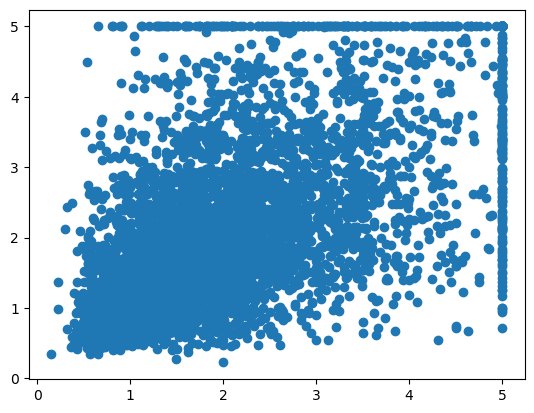

In [18]:
# Make sure to do the following - 
# 1. Use your algorithm to predict the median home value of every instance in the test set. Report the RMSE ("test RMSE")
t_start = time.time()

test_Y_hat = knn_predict(train_X, test_X, train_Y, k = 1, L = 2)
test_rmse = compute_rmse(test_Y_hat, test_Y)
print(f"test RMSE: {test_rmse:.3f}")

t_test = time.time() - t_start

# 2. Use your algorithm to predict the median home value of every instance in the training set and report the training RMSE.
train_Y_hat = knn_predict(train_X, train_X, train_Y, k = 1, L = 2)
train_rmse = compute_rmse(train_Y_hat, train_Y)
print(f"train RMSE: {train_rmse:.3f}")

# 2b. confirm train including self is 
train_Y_hat_self = knn_predict(train_X, train_X, train_Y, k = 1, L = 2, exclude_self=False)
train_rmse_self = compute_rmse(train_Y_hat_self, train_Y) # <-- it is including itself
print(f"train RMSE_w_self: {train_rmse_self:.3f}")

assert train_rmse_self == 0.0 # Good! Train RMSE should be 0

# 3. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis.
plt.scatter(test_Y, test_Y_hat)

# 4. Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.
print(f"Total time for test set: {t_test:.3f}s")


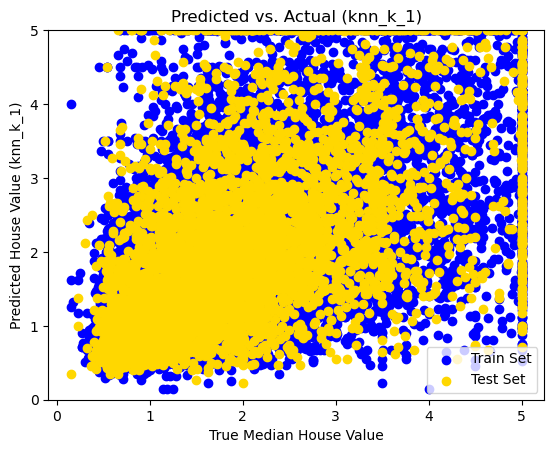

In [15]:
# More Scatter Plots
plt.figure(0)
plt.scatter(train_Y, train_Y_hat, color='blue', label = 'Train Set')
plt.scatter(test_Y, test_Y_hat, color='gold', label = 'Test Set')
plt.xlabel('True Median House Value')
plt.ylabel('Predicted House Value (knn_k_1)')
plt.legend()
plt.title('Predicted vs. Actual (knn_k_1)')
plt.ylim(0, max(cal_df[target]))
plt.show()


*your answer here*

5) How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.4? Explain the

    It's actually a bit worse than 1.4 but not too much. It's better than 1.3. This is probably just indicative that this isn't a very expanatory set of features, the normalization isn't ideal and the capped values (MedHouseVal=~5) stand out. But will require more experimentation

### 2.3 Optimization

Try to increase the performance of your nearest neighbor algorithm by adding features that you think might be relevant, and by using different values of L in the distance function.  Try a model that uses a different set of 2 features, then try at least one model that uses more than 4 features, then try using a different value of L.  If you're having fun, try a few different combinations of features and L! Use the test set to report the RMSE values.

What combination of features and distance function provide the lowest RMSE on the test set?  Do your decisions affect the running time of the algorithm?

**Note:** For this and all subsequent questions, you should use normalized features. 

In [16]:
# your code here
# Make a function to run knn_predict on various list of columns
def knn_run(col_list, k=1, L=2):
    # Set X
    train_X_ = cal_df_train__norm[col_list].values
    test_X_ = cal_df_test__norm[col_list].values
    
    # Set Y
    train_Y_ = cal_df_train__norm['MedHouseVal'].values
    
    test_Y_ = cal_df_test__norm['MedHouseVal'].values
    test_Y_hat_ = knn_predict(train_X_, test_X_, train_Y_, k=k, L=L)

    return test_Y_hat_


# standard train_cols
compute_rmse(knn_run(train_cols), test_Y)
compute_rmse(knn_run(train_cols), test_Y)



1.0326683160298653

In [17]:
# ['MedIncNorm', 'HouseAgeNorm', 'AveRoomsNorm', 'AveBedrmsNorm', 'PopulationNorm', 'AveOccupNorm', 'DistCoastNorm', 'InlandNorm']

def knn_trial(col_list, name = '', Y = test_Y, k=1, L=2, output=True):
    start_time = time.time()
    y_hat = knn_run(col_list, k=1, L=2)
    rmse = compute_rmse(y_hat, Y)
    total_time = time.time() - start_time

    if output:
        print(f"{name} RMSE:  \t{rmse:.3f} -- (run-time: {total_time:.3f}s)")
    return rmse


# Raw Feats: Let's try without the normalization out of curiosity -- about the same
raw_feats__cols = [x.replace('Norm','') for x in train_cols]
knn_trial(raw_feats__cols, 'raw_feats')

# Four Feats: ['DistCoastNorm', 'MedIncNorm', 'AveBedrmsNorm','PopulationNorm']
two_feats__cols = ['DistCoastNorm', 'MedIncNorm']
knn_trial(two_feats__cols, 'two_feats')

# Four Feats: ['DistCoastNorm', 'MedIncNorm', 'AveBedrmsNorm','PopulationNorm']
four_feats__cols = ['DistCoastNorm', 'MedIncNorm', 'AveBedrmsNorm','PopulationNorm']
knn_trial(four_feats__cols, 'four_feats')

# All: ['MedIncNorm', 'HouseAgeNorm', 'AveRoomsNorm', 'AveBedrmsNorm', 'PopulationNorm', 'AveOccupNorm', 'DistCoastNorm', 'InlandNorm']
all_feats__cols = ['MedIncNorm', 'HouseAgeNorm', 'AveRoomsNorm', 'AveBedrmsNorm', 'PopulationNorm', 'AveOccupNorm', 'DistCoastNorm', 'InlandNorm']
knn_trial(all_feats__cols, 'all_feats')

# All: ['MedIncNorm', 'HouseAgeNorm', 'AveRoomsNorm', 'AveBedrmsNorm', 'PopulationNorm', 'AveOccupNorm', 'DistCoastNorm', 'InlandNorm']
all_feats_L4__cols = ['MedIncNorm', 'HouseAgeNorm', 'AveRoomsNorm', 'AveBedrmsNorm', 'PopulationNorm', 'AveOccupNorm', 'DistCoastNorm', 'InlandNorm']
knn_trial(all_feats_L4__cols, 'all_feats_L4', L = 4)

raw_feats RMSE:  	1.040 -- (run-time: 5.370s)
two_feats RMSE:  	0.963 -- (run-time: 5.285s)
four_feats RMSE:  	0.928 -- (run-time: 5.351s)
all_feats RMSE:  	0.822 -- (run-time: 5.624s)
all_feats_L4 RMSE:  	0.822 -- (run-time: 5.542s)


0.822432679538259

*your answer here*

The one using all features seems to have the best accuracy, which is unsurprising since it has the most information. This does not seem to affect the runtime enough to make much of a difference.

### 2.4 K-nearest neighbors algorithm

Now, implement the K-nearest neighbors algorithm and repeat the analysis in 2.2 by using 5 neighbors (`K=5`). The function(s) you write here will be used several more times in this problem set, so do your best to write efficient code! Make sure to do the following:
1. Use your algorithm to predict the median home value of every instance in the test set. Report the RMSE ("test RMSE")
2. Use your algorithm to predict the median home value of every instance in the training set and report the training RMSE.
3. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis.
4. Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.
5. How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.4?

**Note:** Runtime should not exceed a couple of minutes. If its taking longer then we strongly suggest you go back to your code and make it more efficient. 

test RMSE: 0.783
train RMSE: 0.794


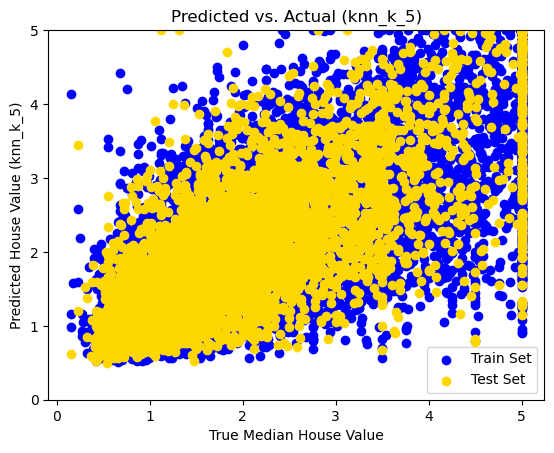

Total time for test set: 5.438s


In [140]:
# your code here
#knn_trial(train_cols, 'train_cols_k5', k=5)
#knn_trial(all_feats__cols, 'train_cols_k5', k=5)
#knn_trial(all_feats__cols, 'train_cols_k1', k=1)
#knn_trial(all_feats__cols, 'train_cols_k1', k=10)
#knn_trial(train_cols, 'train_cols_k1', k=10)

# 1) Use your algorithm to predict the median home value of every instance in the test set. Report the RMSE ("test RMSE")
# knn_predict(X_train, X_test, Y_train, k=1, L=2, exclude_self=True):

t_start = time.time()

test_k5__Y_hat = knn_predict(train_X, test_X, train_Y, k=5, L=2, exclude_self=True)
test_k5__rmse = compute_rmse(test_k5__Y_hat, test_Y)
print(f"test RMSE: {test_k5__rmse:.3f}")

t_test_k5 = time.time() - t_start

# 2) Use your algorithm to predict the median home value of every instance in the tarining set and report the training RMSE.
t_start = time.time()

train_k5__Y_hat = knn_predict(train_X, train_X, train_Y, k=5, L=2, exclude_self=True)
train_k5__rmse = compute_rmse(train_k5__Y_hat, train_Y)
print(f"train RMSE: {train_k5__rmse:.3f}")

t_train_k5 = time.time() - t_start

# 3) Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis
plt.figure(0)
plt.scatter(train_Y, train_k5__Y_hat, color='blue', label = 'Train Set')
plt.scatter(test_Y, test_k5__Y_hat, color='gold', label = 'Test Set')
plt.xlabel('True Median House Value')
plt.ylabel('Predicted House Value (knn_k_5)')
plt.legend()
plt.title('Predicted vs. Actual (knn_k_5)')
plt.ylim(0, max(cal_df[target]))
plt.show()

# 4) Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set
print(f"Total time for test set: {t_test_k5:.3f}s")

5) How does the perforcmance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.4?

This one is much better than 1.4

### 2.5 Cross-Validation

How can we choose K without overfitting? As discussed during lecture time, one possible solution is to use [k-fold cross-validation][1] on the training sample.  Here you must implement a simple k-fold cross-validation algorithm yourself.  The function(s) you write here will be used several more times in this problem set, so do your best to write efficient code! 

Use 20-fold cross-validation and report the average RMSE for your K-nearest neighbors model using Euclidean distance with the same set of features used in 2.4 (`MedIncNorm, HouseAgeNorm and AveRoomsNorm`) and 5 neighbors (`K=5`)  as well as the total running time for the full run of 20 folds.  

In other words, randomly divide your training dataset (created in 1.2) into 20 equally-sized samples. For each of the 20 iterations (the "folds"), use 19 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for validation.  Compute the RMSE of that particular validation set, then move on to the next iteration.  

 - Report the average cross-validated RMSE across the 20 iterations and compare to the result you obtained in 2.3. What do you observe?
 - Report the runtime of your algorithm.How does it compare to your previous results?

[1]: http://en.wikipedia.org/wiki/Cross-validation_(statistics)
[2]: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

**Note 1:** Runtime should not exceed a couple of minutes. If its taking longer then we strongly suggest you go back to your code and make it more efficient. 

**Note 2**: The sklearn package has a built-in [K-fold][2] iterator -- you should *not* be invoking that or any related algorithms in this section of the problem set.

**Note 3:** To perform any randomized operation, only use functions in the *numpy library (np.random)*. Do not use other packages for random functions.

In [132]:
# your code here

# Split into folds

start_time = time.time()
n_folds = 20 
# n_holdout_folds = 1 <- unused

# Split into test/train folds
ids = cal_df_train__norm.index.values
np.random.shuffle(ids)
folds_ids = np.array_split(ids, n_folds)

# Run cross-validation
fold_rmses_list = np.zeros(n_folds)
for i in range(len(folds_ids)):
    # Split Folds
    test_ids = folds_ids[i]
    train_ids = np.concatenate(folds_ids[:i] + folds_ids[i+1:])
    assert len(train_ids) + len(test_ids) == len(ids)

    # Set X/Y
    test_fold__X = cal_df_train__norm.loc[test_ids][train_cols].values
    train_fold__X = cal_df_train__norm.loc[train_ids][train_cols].values

    test_fold__Y = cal_df_train__norm.loc[test_ids][target].values
    train_fold__Y = cal_df_train__norm.loc[train_ids][target].values

    # knn_predict(X_train, X_test, Y_train, k=1, L=2, exclude_self=True):
    # Run the model
    test_fold__Y_hat = knn_predict(train_fold__X, test_fold__X, train_fold__Y, k=5)
    test_fold__rmse = compute_rmse(test_fold__Y_hat, test_fold__Y)

    fold_rmses_list[i] = test_fold__rmse
    print(f"{i: }: {test_fold__rmse: .3f}")

kfolds_time = time.time() - start_time

 0:  0.785
 1:  0.841
 2:  0.788
 3:  0.763
 4:  0.784
 5:  0.808
 6:  0.783
 7:  0.796
 8:  0.826
 9:  0.851
 10:  0.792
 11:  0.784
 12:  0.788
 13:  0.785
 14:  0.712
 15:  0.757
 16:  0.779
 17:  0.827
 18:  0.805
 19:  0.800


In [138]:
min_rmse_fold = fold_rmses_list.argmin()
print(f"Cross validation had a mean RMSE of {np.mean(fold_rmses_list):.3f} across {n_folds} folds.\n \
Fold {min_rmse_fold} is most accurate with RMSE of: {fold_rmses_list[min_rmse_fold]:.3f}\n \
When compared
The algorithm ran in {kfolds_time:.2f}s")

Cross validation had a mean RMSE of 0.793 across 20 folds.
 Fold 14 is most accurate with RMSE of: 0.712
 The algorithm ran in 14.9368s


**Observations**

It appears similar in accuracy (.793 vs. .783) when compared to the algorithm in 2.4. However, this is not a fair comparison - since the cross-validation is only running on the training set and is comparing to itself in the training set, while 2.4 is comparing to a separate holdout. If we want to compare to a separate holdout we can look below. We can see the best folds are better than the 2.4 method but on the whole they are less accurate.

The run-time is interestingly only about three times slower (14.9s vs 5.4s) than the traditional model in 2.4



### 2.6 Using cross validation to find the optimal value for K

Compute the cross-validated RMSE for values of K between 1 and 25 using 10-fold cross-validation and L2 normalization.  Use the following features in your model: `MedIncNorm, HouseAgeNorm and AveRoomsNorm` .  Create a graph that shows how cross-validated RMSE changes as K increases from 1 to 25.  Label your axes, and summarize what you see.  What do you think is a reasonable choice of K for this model?

Finally, "train" a K-nearest neighbor model using the value of K that minimized the cross-validated RMSE and report the test RMSE. (Continue to use L2 normalization and the same set of features). How does the test RMSE compare to the cross-validated RMSE, and is this what you expected? 

**Note:** Runtime should not exceed ~30 min. If its taking longer then we strongly suggest you go back to your code and make it more efficient. 

In [175]:
# your code here
n_folds = 10
feat_cols = ['MedIncNorm', 'HouseAgeNorm', 'AveRoomsNorm']
target = 'MedHouseVal'
max_k = 25

start_time = time.time()

# Split into test/train folds
ids = cal_df_train__norm.index.values
np.random.shuffle(ids)
folds_ids = np.array_split(ids, n_folds)

# Set outptu arrays
fold_k__rmse_matrix = np.zeros([max_k+1, n_folds])
fold_k__times = np.zeros([max_k+1])

# Loop over Ks
for k_in in range(1, max_k+1):
    print(f"k = {k_in}")
    t_start = time.time()
    # Run cross-validation
    for i in range(len(folds_ids)):
        # Split Folds
        test_ids = folds_ids[i]
        train_ids = np.concatenate(folds_ids[:i] + folds_ids[i+1:])
        assert len(train_ids) + len(test_ids) == len(ids)

        # Set X/Y
        test_fold__X = cal_df_train__norm.loc[test_ids][feat_cols].values
        train_fold__X = cal_df_train__norm.loc[train_ids][feat_cols].values

        test_fold__Y = cal_df_train__norm.loc[test_ids][target].values
        train_fold__Y = cal_df_train__norm.loc[train_ids][target].values

        # knn_predict(X_train, X_test, Y_train, k=1, L=2, exclude_self=True):
        # Run the model
        test_fold__Y_hat = knn_predict(train_fold__X, test_fold__X, train_fold__Y, k=k_in)
        test_fold__rmse = compute_rmse(test_fold__Y_hat, test_fold__Y)

        fold_k__rmse_matrix[k_in][i] = test_fold__rmse
        print(f"{i: }: {test_fold__rmse: .3f}")

    fold_k__times[i] = time.time() - start_time

kfolds_total = time.time() - start_time

k = 1
 0:  1.047
 1:  1.037
 2:  1.005
 3:  1.002
 4:  1.018
 5:  1.014
 6:  1.049
 7:  1.036
 8:  1.018
 9:  1.015
k = 2
 0:  0.891
 1:  0.895
 2:  0.878
 3:  0.875
 4:  0.888
 5:  0.897
 6:  0.889
 7:  0.914
 8:  0.885
 9:  0.855
k = 3
 0:  0.848
 1:  0.829
 2:  0.820
 3:  0.819
 4:  0.858
 5:  0.855
 6:  0.849
 7:  0.859
 8:  0.833
 9:  0.816
k = 4
 0:  0.823
 1:  0.798
 2:  0.788
 3:  0.794
 4:  0.833
 5:  0.815
 6:  0.827
 7:  0.822
 8:  0.826
 9:  0.793
k = 5
 0:  0.811
 1:  0.777
 2:  0.760
 3:  0.773
 4:  0.810
 5:  0.799
 6:  0.812
 7:  0.800
 8:  0.808
 9:  0.776
k = 6
 0:  0.801
 1:  0.769
 2:  0.743
 3:  0.758
 4:  0.804
 5:  0.789
 6:  0.800
 7:  0.786
 8:  0.786
 9:  0.763
k = 7
 0:  0.792
 1:  0.763
 2:  0.738
 3:  0.755
 4:  0.802
 5:  0.779
 6:  0.796
 7:  0.785
 8:  0.781
 9:  0.754
k = 8
 0:  0.783
 1:  0.759
 2:  0.737
 3:  0.752
 4:  0.793
 5:  0.771
 6:  0.791
 7:  0.775
 8:  0.776
 9:  0.748
k = 9
 0:  0.778
 1:  0.756
 2:  0.731
 3:  0.749
 4:  0.786
 5:  0.765


/var/folders/t8/dm9l8xy95mv0d_75b2m8r5nw0000gn/T/ipykernel_75871/3943140954.py:4: RuntimeWarning: Mean of empty slice
  fold_k__rmse_means = np.nanmean(fold_k__rmse_matrix, axis = 1) # calculate means


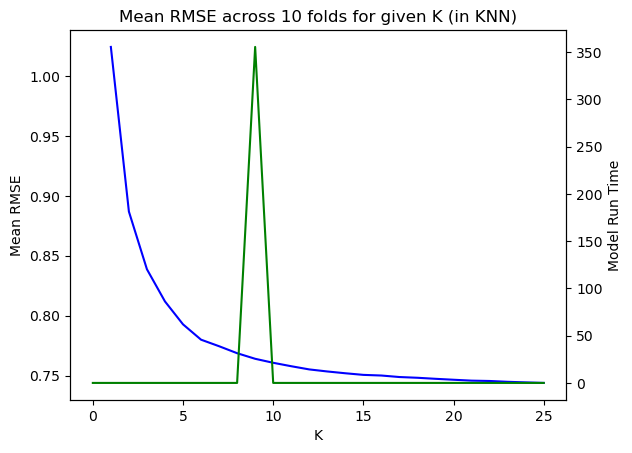

In [183]:
# Now calculate means, minimize, and re-run on the holdout itself
# fold_k__rmse_matrix[0] = np.nan # <- remove the k = 0

fold_k__rmse_means = np.nanmean(fold_k__rmse_matrix, axis = 1) # calculate means

fig, ax1 = plt.subplots()

# First Axis is RMSE
x_vals = np.arange(0, max_k+1)
ax1.plot(x_vals, fold_k__rmse_means, 'b-')
ax1.set_xlabel('K')
ax1.set_ylabel('Mean RMSE')

# Second Axis is time
ax2 = ax1.twinx() # <- use same X-axis
ax2.plot(x_vals, fold_k__times, 'g-')
ax2.set_ylabel('Model Run Time')

plt.title('Mean RMSE across 10 folds for given K (in KNN)')
plt.show()


*your answer here*

The model improved with every additional K, which is somewhat expected given that it is jsut increasing information and even at 25, K is not approaching the size of the training set (it is still less than 1/500th), thus it is still useful to take the average. It could maybe be improved by weighting things based on distance, using the same or a different L as a decay function

Given that the time gains are also negligible (aside from what looks like a random spike), complexity is not much of a consideration. But using the "elbow method", there appears to be a potential optimum at k=6 so we can try that below. 

We thus see an RMSE of .768, which is better than anything we saw above. Good job!

In [189]:
# K = 6
test_k6__y_hat = knn_predict(train_X, test_X, train_Y, k=6, L=2)
test_k6__rmse = compute_rmse(test_k6__y_hat, test_Y)

print(f"RMSE: {test_k6__rmse:.3f}")


RMSE: 0.768


---

# Part III: Overfitting in Model Selection and Nested Cross Validation 


In this last part of the problem set, we will examine why overfitting is a serious concern when estimating hyperparameters and how to address it. 

**For this part of the problem set you are allowed to use machine learning libraries. We don't expect you to use your own algorithms developed in part 2.** We strongly suggest that you use the following libraries and resources, but feel free to choose your favorite Python ML libraries.

In [209]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import joblib

For this part of the problem set we will no longer be using the California Housing Dataset. Instead, we will generate our own synthetic data. The advantage of doing so is that we get to choose the data generating process. We will use the knowledge about the data generating process to test the robustness of different approaches to estimating out-of-sample performance.

We will attempt the following classification problem: predict a binary response variable $y \sim Bernoulli(p=1/2)$ from a set of independent features $X=[x_{1},...,x_{J}]$ where $x_{j} \sim Unif(a=0,b=1)$, $1 \leq j \leq J$. 

You can use the following function to generate samples from this distribution.

In [210]:
def generate_random_sample(nobs,J):
    X = pd.DataFrame(np.random.random_sample(size=(nobs, J)), columns=[f'feature_{x}' for x in range(J)])
    y = np.random.binomial(n=1,p=1/2,size=nobs)
    return X,y

X_train, y_train = generate_random_sample(nobs=2*10**3,J=100)

### 3.1 Out-of-sample performance

We are going to be using the area under the ROC curve (AUC-ROC) as the evaluation score. What kind of out-of-sample performance would you expect from classification models trained and tested on this data? Test whether your intuition is correct by carrying out the following iterative procedure:

1. For each iteration in 1,2,3,...,50:
    * Generate a training sample containing 2,000 observations and J=100 features. Likewise, generate a test sample containing 200 observations and J=100 features. 
    * Train some K-nearest neighbors model on the training sample with some arbitrary choice of K (no need to cross validate the choice of K or put any work into it, we'll get to that later on).
    * Evaluate the AUC-ROC on the test set.
2. Plot a histogram of the test AUC-ROC scores.
3. Report the average of the test AUC-ROC scores.

In [233]:
# your code here
TRAIN_n = 2000
TEST_n = 200

aucs = np.zeros(51)

for i in range(1,51):
    X_train, y_train = generate_random_sample(nobs=TRAIN_n, J=100)
    X_test, y_test = generate_random_sample(nobs=TEST_n, J=100)

    knn = KNeighborsClassifier(n_neighbors=5)

    knn.fit(X_train.values, y_train)
    y_hat = knn.predict(X_test.values)

    aucs[i] = roc_auc_score(y_test, y_hat)

aucs[0] = np.nan

knn = KN
cross_val_score()

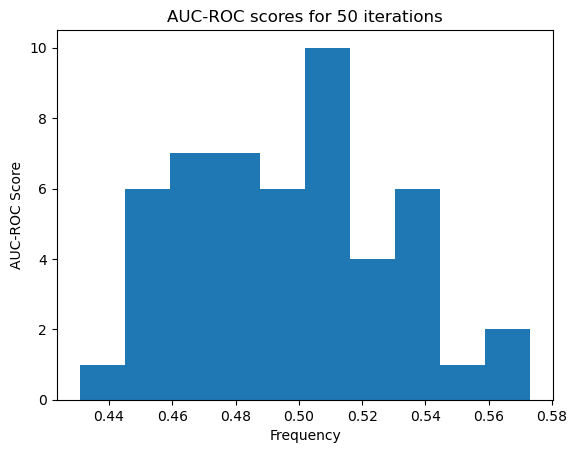

mean AUC: 0.497


In [234]:
plt.hist(aucs)
plt.title('AUC-ROC scores for 50 iterations')
plt.xlabel('Frequency')
plt.ylabel('AUC-ROC Score')
plt.show()

print(f"mean AUC: {np.nanmean(aucs):.3f}")

*your answer here*

The Mean AUC is .497 - essentially random chance (which makes sense)

### Fix a sample

In real life settings we wouldn't be able to draw test and train samples at will. For the rest of the pset (3.2-3.6) we will fix a training and test sample:

In [235]:
X_train,y_train = generate_random_sample(nobs=2*10**3,J=100)
X_test,y_test = generate_random_sample(nobs=2*10**2,J=100)

### 3.2 k-fold cross-validation 
Use 10-fold cross-validation on the train sample to find the optimal K and report the hyperparameter value. Report also the average of the cross validated scores for the optimal hyperparameter value. 

In [276]:
# your code here
kf = KFold(n_splits=10, shuffle=True, random_state=923)

splits_aucs = np.zeros(10)
i = 0
# for train_fold__ix, test_fold__ix in kf.split(X_train):
#     # Split Fold Train
#     X__train_fold = X_train.loc[train_fold__ix].values
#     y__train_fold = y_train[train_fold__ix]
    
#     # Split fold test (note: here from train)
#     X__test_fold = X_train.loc[test_fold__ix].values
#     y__test_fold = y_train[test_fold__ix]

#     # Train Model
#     model = KNeighborsClassifier()
#     model.fit(X__train_fold, y__train_fold)

#     # Predict
#     y_hat = model.predict(X__test_fold)

#     splits_aucs[i] = roc_auc_score(y__test_fold, y_hat)
#     i = i+1

knn = KNeighborsClassifier()
cross_val_scores = cross_val_score(knn, X_train.values, y_train, cv=kf, scoring='roc_auc')

print(cross_val_scores)
print(splits_aucs)

[0.50426536 0.50715644 0.56612645 0.53946314 0.50940094 0.52723378
 0.49749975 0.56562625 0.44606311 0.48417208]
[0.46918908 0.49679712 0.54161665 0.53605769 0.52955296 0.52631579
 0.49449945 0.57142857 0.46738583 0.54261364]


### 3.3 Nested cross-validation

Use nested cross validation ([3],[4],[5],[6]) on the training sample. In the outer loop you should be estimating model performance and in the inner loop you should be doing regular k-fold cross validation to find the optimal K. Use 10 folds for the inner cv and 3 folds for the outer cv. Report the average of the cross-validated scores of the outer loop.

[3]: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py
[4]: https://inria.github.io/scikit-learn-mooc/python_scripts/cross_validation_nested.html#:~:text=As%20a%20conclusion%2C%20when%20optimizing,validation%20are%20often%20overly%20optimistic.
[5]: https://stats.stackexchange.com/questions/65128/nested-cross-validation-for-model-selection/65156#65156
[6]: https://stats.stackexchange.com/questions/232897/how-to-build-the-final-model-and-tune-probability-threshold-after-nested-cross-v/233027#233027

In [ ]:
# your code here

### 3.4 Take stock of the results so far

Based on the results of 3.1, 3.2 and 3.3, what can you say about estimating out-of-sample performance? Is the average of the cross-validated scores a good estimator? How about the average of the nested cross-validated scores? Are they underestimating or overestimating true out-of-sample performance?

*your answer here*

### 3.5 Comparing k-fold and nested cross-validation [extra-credit]

We would like to better assess the difference between the k-fold and nested cross-validation scores and make sure that the results we observed in 3.2 and 3.3 are not a fluke. To do this, repeat both experiments 50 times. In each iteration, pass a different value for the "random_state" parameter in the KFold function to ensure that there is variation in the fold splitting. 

In a single figure, plot two histograms. One showing the distribution of the k-fold scores, another showing the distribution of the nested scores. Use gold for the color of the objects related to the nested scores and blue for the color of the objects related to the k-fold scores. 

**Note 1**: you should NOT be generating a new sample -- continue working with the dataset fixed ahead of question 3.2.

**Note 2**: Runtime should not exceed 30 min. If its taking longer then we strongly suggest you go back to your code and make it more efficient.

In [ ]:
# your code here

### 3.6 Conclusion [extra-credit]

Based on the figure from 3.5, would you adjust your answer to question 3.4? In a couple of sentences, explain why overfitting can arise when doing model selection, and why nested cross-validation is a useful tool in preventing it. 

*your answer here*